In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from helpers import sql

warnings.filterwarnings('ignore')

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('display.float_format', '{:.1f}'.format)

In [2]:
requests = sql("""
    SELECT * FROM csas2_csasrequest;
""")

request_reviews = sql("""
    SELECT * FROM csas2_csasrequestreview;
""")

processes = sql("""
    SELECT * FROM csas2_process
        JOIN csas2_csasoffice ON csas2_process.lead_office_id = csas2_csasoffice.id
        JOIN shared_models_region ON csas2_csasoffice.region_id = shared_models_region.id;
""")
n_office = 7
n_region = 9
processes.columns = (
    [x for x in processes.columns[:-(n_office + n_region)]] 
    + ['office_' + x for x in processes.columns[-(n_office + n_region):-n_region]]
    + ['region_' + x for x in processes.columns[-n_region:]]
)

tor = sql("""
    SELECT * FROM csas2_termsofreference;
""")
tor["year"] = tor.created_at.dt.year

meetings = sql("""
    SELECT * FROM csas2_meeting;
""")
meetings["year"] = meetings.created_at.dt.year

invitees = sql("""
    SELECT
        csas2_invitee.status AS invitee_status,
        invitation_sent_date, meeting_id, person_id,
        region_id, comments, affiliation, job_title_en, job_title_fr,
        created_at AS meeting_created, updated_at AS meeting_updated, location AS meeting_location
    FROM csas2_invitee 
    JOIN csas2_meeting ON csas2_meeting.id = csas2_invitee.meeting_id;
""")
invitees['year'] = invitees.meeting_created.dt.year

documents =  sql("""
    SELECT * FROM csas2_document
        JOIN csas2_documenttype ON csas2_document.document_type_id = csas2_documenttype.id
        JOIN csas2_documenttracking ON csas2_documenttracking.document_id = csas2_document.id;
""")
n_doctype = 8
n_tracking = 52
documents.columns = (
    [x for x in documents.columns[:-(n_doctype + n_tracking)]] 
    + ['doctype_' + x for x in documents.columns[-(n_doctype + n_tracking):-n_tracking]]
    + ['tracking_' + x for x in documents.columns[-n_tracking:]]
)

changelog = sql("""
    SELECT * FROM csas2_changelog;
""") 

# Helper Functions

In [3]:
def null_heatmap(df, figsize=(4,12)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.notna().mean().to_frame(), annot=True, fmt='.0%', cmap='RdBu', cbar=False, vmin=0.2, vmax=0.8)
    plt.tick_params(labelbottom=False)
    plt.show()
    

# Requests

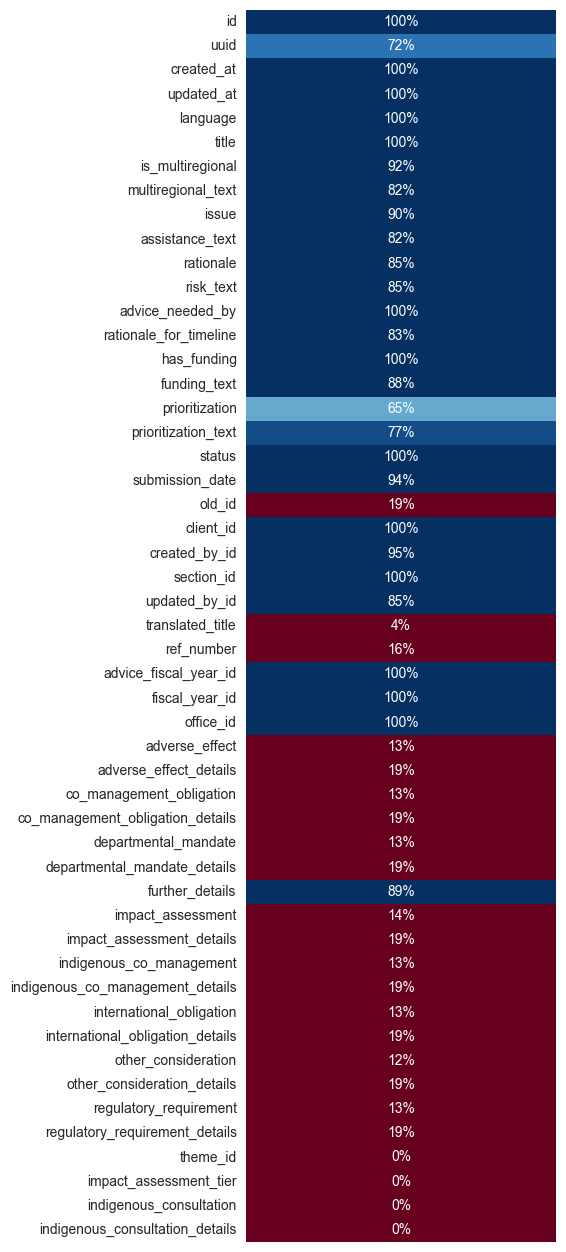

In [4]:
null_heatmap(requests, figsize=(4,16))

# CSAS Reviews

In [5]:
new_reviews = request_reviews[request_reviews.sufficient_data.notna()].copy().reset_index(drop=True)

review_cols = [
    'id', 'decision',
    'is_feasible', 'is_valid', 
    'science_question', 'specific_advice_required', 'lit_review', 'new_advice',
    'sufficient_capacity', 'sufficient_data', 'sufficient_time',
]

new_reviews['is_applicable_predicted'] = (
        (new_reviews.science_question == 1) & 
        (new_reviews.specific_advice_required == 1) &
        (new_reviews.lit_review == 0) &
        (new_reviews.new_advice == 0)
)
new_reviews['is_feasible_predicted'] = (
        (new_reviews.sufficient_capacity == 1) & 
        (new_reviews.sufficient_data == 1) &
        (new_reviews.sufficient_time == 1)
)

In [6]:
# is this ever different than predicted?
(new_reviews['is_feasible_predicted'] == new_reviews['is_feasible']).value_counts()

True    211
Name: count, dtype: int64

In [7]:
(new_reviews['is_applicable_predicted'] == new_reviews['is_valid']).value_counts()
# hmmmm


True     209
False      2
Name: count, dtype: int64

In [8]:
# looks fine, don't need to predict the columns
new_reviews.loc[~(new_reviews['is_applicable_predicted'] == new_reviews['is_valid']), review_cols].T

,55,111
id,1002,1202
decision,1,NaN
is_feasible,1,1
is_valid,NaN,NaN
science_question,NaN,NaN
specific_advice_required,NaN,NaN
lit_review,NaN,NaN
new_advice,NaN,NaN
sufficient_capacity,1,1
sufficient_data,1,1


In [9]:
# however, we should drop these so they don't mess with calculations
new_reviews = new_reviews[(new_reviews['is_applicable_predicted'] == new_reviews['is_valid'])]

In [10]:
review_rec_cols = [
    'id', 'decision',
    'is_feasible', 'is_valid', 
]
new_reviews['decision_matches_recommended'] = (
    ((new_reviews.decision == 1) & (new_reviews.is_feasible == 1) & (new_reviews.is_valid == 1)) |
    ((new_reviews.decision != 1) & ((new_reviews.is_feasible == 0) | (new_reviews.is_valid == 0)))
)

In [11]:
new_reviews['decision_matches_recommended'].value_counts()

decision_matches_recommended
True     178
False     31
Name: count, dtype: int64

In [13]:
new_reviews.loc[~new_reviews['decision_matches_recommended'], 'decision'].value_counts()

decision
1    22
3     3
2     2
Name: count, dtype: int64

In [14]:
# why are we screening in infeasible requests?

pd.DataFrame(new_reviews.loc[
    ((~new_reviews['decision_matches_recommended']) & (new_reviews.decision == 1)), 
    'override_reason'
].unique(), columns=['explanation']).sort_values('explanation').reset_index(drop=True)

,explanation
0,"If data becomes available, this request will be feasible and we can complete this request. Sea scallop (ranking 2) is prioritized over sea cucumber (ranking 3)."
1,Screened in but capacity and time are limiting factors
2,"TMM - due to time required, should be deferred to 26/27."
3,from Sarah Deller - priority has changed for SARP; from Andrew Taylor - Science will not have data for 2025/26
4,meeting now scheduled
5,plan are underway - work will begin in 2023-24
6,refer to recommendation explanation
7,"refer to recommendation explanation. no answers in spreadsheet to whether there is sufficient capacity, data or time,"
8,refer to the recommendation explanation
9,screen in/defer


# Processes

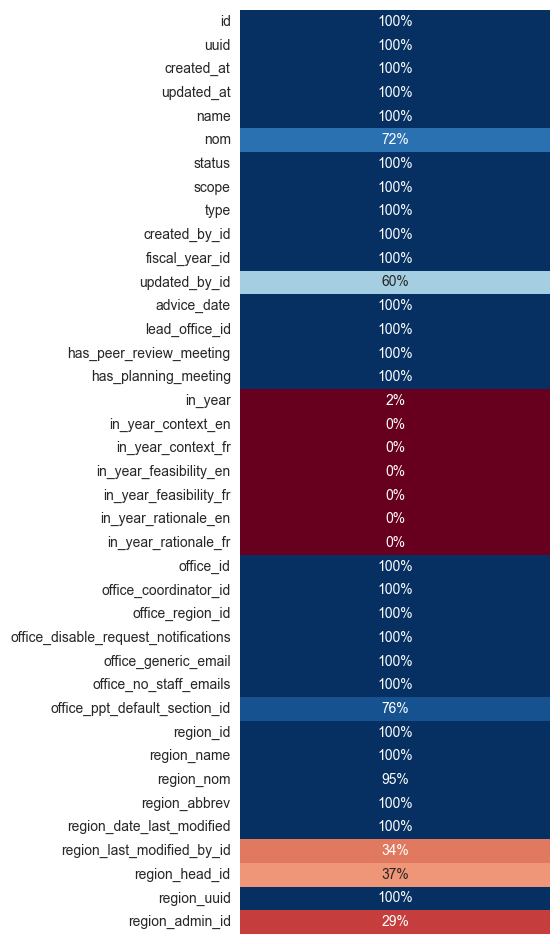

In [15]:
null_heatmap(processes)

# ToR

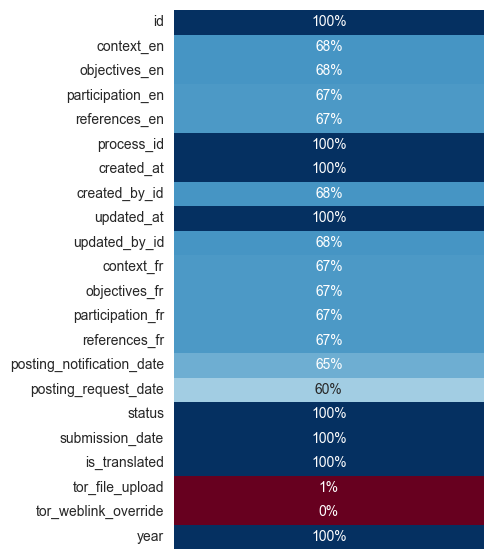

In [16]:
# approved ToR
null_heatmap(tor[tor.status>=35], figsize=(4, 7))

# Meetings

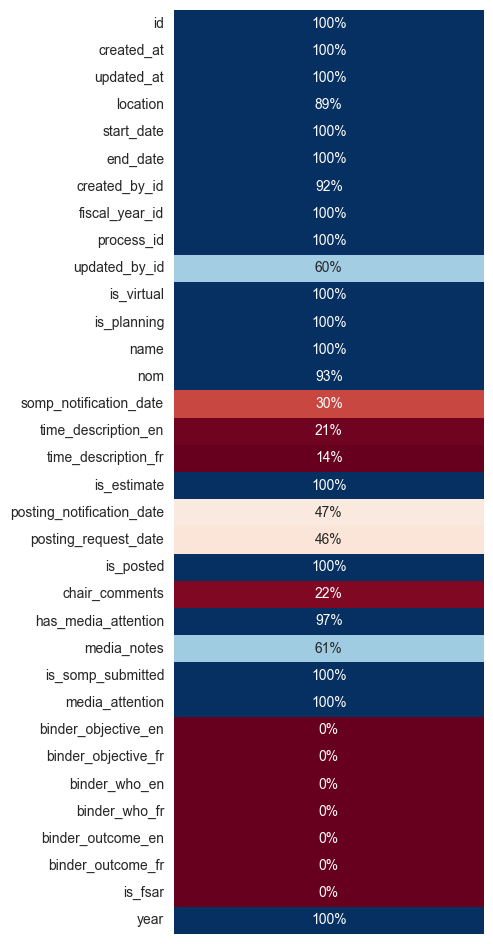

In [17]:
null_heatmap(meetings)

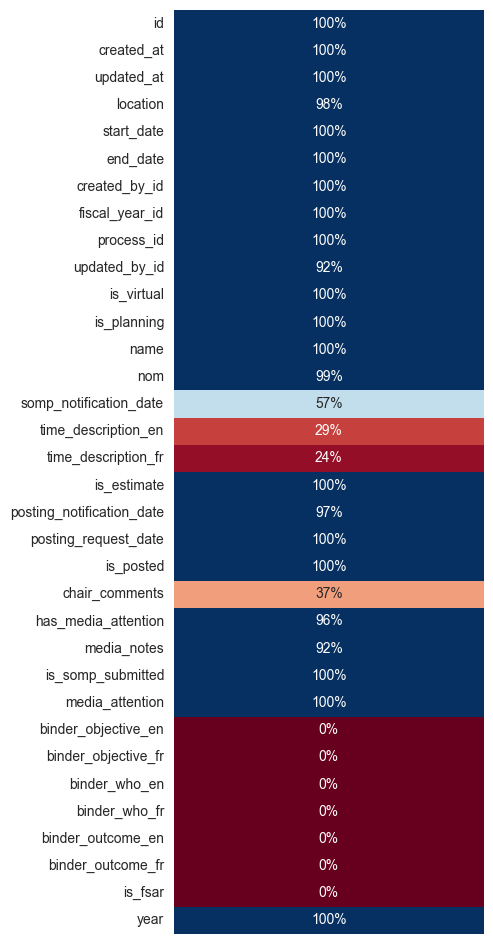

In [18]:
null_heatmap(meetings[meetings.posting_request_date.notna()])

# Invitees

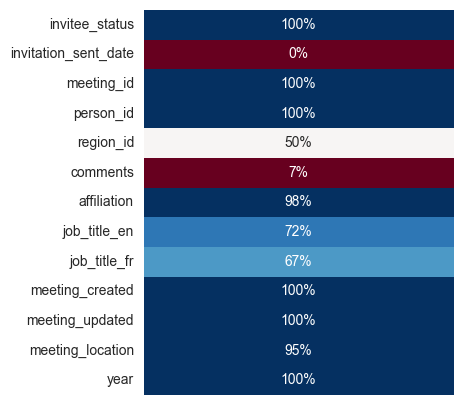

In [19]:
null_heatmap(invitees, figsize=(4, 5))

In [20]:
# invitee stats? need to break it down more
pd.DataFrame(invitees.meeting_id.value_counts()).describe()

,count
count,534
mean,9
std,12
min,1
25%,3
50%,5
75%,8
max,75


In [21]:
percentiles=[0.16, 0.84, 0.025, 0.975, 0.0015, 0.9985]

pd.DataFrame(invitees.groupby('year').meeting_id.value_counts().unstack(level=0)).describe(percentiles=percentiles).T[['mean', '2.5%', '16%', '50%', '84%', '97.5%']]

# TODO: compliance is definitely dropping in this module, year on year - compare current version versus 2021 version to see if anything new is added

,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,12,1,2,5,27,63
2022,8,1,3,4,12,42
2023,11,2,3,5,12,53
2024,8,1,3,5,10,37
2025,6,2,3,5,7,20


In [22]:
# how many are external?
invitees['is_dfo'] = (invitees.affiliation.str.upper().str.contains("DFO")) | (invitees.affiliation.str.upper().str.contains("MPO"))
invitees['is_dfo'].value_counts()

is_dfo
True     3460
False    1214
Name: count, dtype: int64

### including meetings with zero invitees

In [23]:
# make sure to add meetings with zero invitees, to not skew counts

print('\nStatistics - Number of Invitees')
all_invitees = invitees.groupby('year').meeting_id.value_counts()
all_meetings_years = meetings.set_index(['year', 'id']).index
all_invitees = all_invitees.reindex(all_meetings_years, fill_value=0)
pd.DataFrame(all_invitees.unstack(level=0)).describe(percentiles=percentiles).T[['mean', '2.5%', '16%', '50%', '84%', '97.5%']]


Statistics - Number of Invitees


,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,8,0,0,2,15,51
2022,7,0,1,4,10,39
2023,4,0,0,0,6,47
2024,7,0,2,5,10,34
2025,5,0,2,4,7,18


In [24]:
print('\nStatistics - Number of External Invitees')
external_invitees = invitees[~invitees.is_dfo].groupby('year').meeting_id.value_counts()
all_meetings_years = meetings.set_index(['year', 'id']).index
external_invitees = external_invitees.reindex(all_meetings_years, fill_value=0)
pd.DataFrame(external_invitees.unstack(level=0)).describe(percentiles=percentiles).T[['mean', '2.5%', '16%', '50%', '84%', '97.5%']]


Statistics - Number of External Invitees


,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,3,0,0,0,5,27
2022,2,0,0,0,0,23
2023,1,0,0,0,0,13
2024,1,0,0,0,1,19
2025,1,0,0,0,3,6


### invitees from ToR

In [25]:
# looks mostly like DFO  

tor.participation_en

0      Fisheries and Oceans Canada (DFO) (Science, and Ecosystems and Fisheries Management)\r\nInvited external experts\r\nProvinces (NB, NS, PEI, QC)\r\nIndigenous organizations\r\nCOSEWIC authors and s...
1                                                                                                                                                                                                             
2      Fisheries and Oceans Canada (Ecosystems and Oceans Science, and Aquatic Ecosystems Management)\r\nAcademia\r\nProvince of PEI, Departments of Environment, Water and Climate Change, and Agriculture...
3                               Fisheries and Oceans Canada (DFO) (Ecosystems and Oceans Science, and Ecosystems and Fisheries Management)\r\nFishing industry\r\nAboriginal organizations\r\nExternal experts
4                    Fisheries and Oceans Canada (DFO), Ecosystems and Oceans Science, Fisheries and Aquaculture Management sectors.\r\nProvincial governments\r\nIndigenous

In [26]:
tor['participant_count_en'] = tor['participation_en'].fillna('').apply(
   lambda x: x.count('\n') + 1 if x.strip() else 0
)
tor['participant_count_fr'] = tor['participation_fr'].fillna('').apply(
   lambda x: x.count('\n') + 1 if x.strip() else 0
)

In [27]:
tor[['participant_count_en', 'participation_en', 'participant_count_fr', 'participation_fr']]

,participant_count_en,participation_en,participant_count_fr,participation_fr
0,5,"Fisheries and Oceans Canada (DFO) (Science, and Ecosystems and Fisheries Management)\r\nInvited external experts\r\nProvinces (NB, NS, PEI, QC)\r\nIndigenous organizations\r\nCOSEWIC authors and s...",5,"Pêches et Océans Canada (MPO) (Sciences, et Écosystèmes et gestion des pêches)\r\nExperts externes invités\r\nProvinces (NB, NS, QC, PE)\r\nOrganisations autochtones\r\nPrésidents et auteur du sou..."
1,0,,0,
2,6,"Fisheries and Oceans Canada (Ecosystems and Oceans Science, and Aquatic Ecosystems Management)\r\nAcademia\r\nProvince of PEI, Departments of Environment, Water and Climate Change, and Agriculture...",6,"Pêches et Océans Canada (Sciences des écosystèmes et des océans, et Gestion des écosystèmes aquatiques)\r\nUniversitaires\r\nProvince de l’Î.-P.-É., ministères de l’environnement, de l’eau et du c..."
3,4,"Fisheries and Oceans Canada (DFO) (Ecosystems and Oceans Science, and Ecosystems and Fisheries Management)\r\nFishing industry\r\nAboriginal organizations\r\nExternal experts",4,"Pêches et Océans Canada (MPO) (Écosystèmes et sciences des océans, et Écosystèmes et gestion des pêches)\r\nIndustrie de la pêche\r\nOrganisations autochtones\r\nExperts externes"
4,4,"Fisheries and Oceans Canada (DFO), Ecosystems and Oceans Science, Fisheries and Aquaculture Management sectors.\r\nProvincial governments\r\nIndigenous organizations\r\nFishing Industry",4,"Pêches et Océans Canada (MPO), Sciences des écosystèmes et océans, Gestion des pêches et de l’aquaculture.\r\nProvinces\r\nOrganisations autochtones\r\nIndustrie de la pêche"
...,...,...,...,...
674,0,,0,
675,0,,0,
676,0,,0,
677,0,None,0,None


In [28]:
(tor['participant_count_en'] == tor['participant_count_fr']).value_counts()

True     656
False     23
Name: count, dtype: int64

In [29]:
tor['participant_count_external'] = tor['participation_en'].fillna('').apply(
   lambda x: sum(1 for line in x.split('\n') if line.strip() and 'dfo' not in line.lower()) if x.strip() else 0
)

### STATS

In [184]:
display_cols = ['mean', '2.5%', '16%', '50%', '84%', '97.5%']

# all participants
display(tor[tor.status==50].groupby('year')['participant_count_en'].describe(percentiles=percentiles)[display_cols])

,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,3,0,0,2,5,6
2022,5,0,2,4,7,16
2023,1,0,0,0,3,11
2024,7,1,2,5,9,31
2025,7,2,2,7,11,12


In [185]:
# external
display(tor[tor.status==50].groupby('year')['participant_count_external'].describe(percentiles=percentiles)[display_cols])

,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,2,0,0,2,4,4
2022,3,0,0,3,5,11
2023,1,0,0,0,2,6
2024,6,0,0,5,7,31
2025,5,0,1,5,7,10


In [183]:
# ToR and Invitees together

print('\nEXTERNAL INVITEES')
display(pd.DataFrame(external_invitees.unstack(level=0)).describe(percentiles=percentiles).T[display_cols])

print('\nEXTERNAL TOR PARTICIPANTS')
display(tor[tor.status==50].groupby('year')['participant_count_external'].describe(percentiles=percentiles)[display_cols])

# TODO: are we actually inviting less people to meetings? or is it just an app thing?


EXTERNAL INVITEES


,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,3,0,0,0,5,27
2022,2,0,0,0,0,23
2023,1,0,0,0,0,13
2024,1,0,0,0,1,19
2025,1,0,0,0,3,6



EXTERNAL TOR PARTICIPANTS


,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,
2021,2,0,0,2,4,4
2022,3,0,0,3,5,11
2023,1,0,0,0,2,6
2024,6,0,0,5,7,31
2025,5,0,1,5,7,10


### invitees from Binder

In [33]:
# invitees from Binder - 2024, 2024, 2025
#  by inspection, checking 3 binders manually (parsing those DOCXs is unwieldy) 

avg_external_participants = (123 + 39 + 70) / (16 + 4 + 8)
round(avg_external_participants, 1)

8.3

# Documents

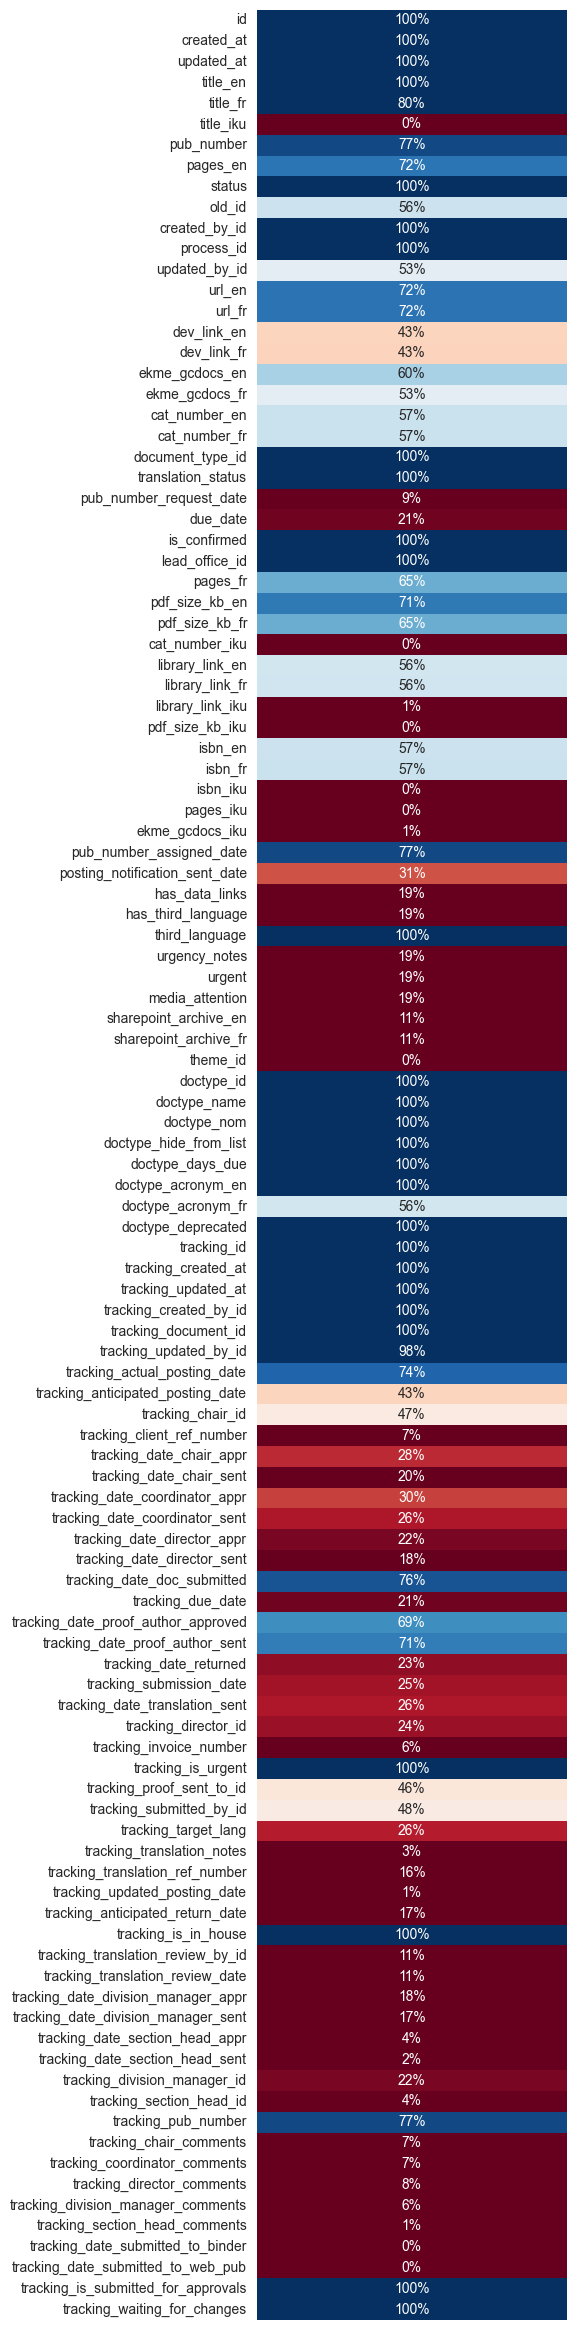

In [34]:
null_heatmap(documents, figsize=(4, 30))

# OVERALL COMPLIANCE CALCS

### CSAS Reviews

In [82]:
review_noncompliance = new_reviews[~new_reviews['decision_matches_recommended']].shape[0] / new_reviews.shape[0]

print(f'Approximately {review_noncompliance:.1%} of CSAS Review decisions are inconsistent with guidelines')

Approximately 14.8% of CSAS Review decisions are inconsistent with guidelines


In [233]:
n_total = new_reviews.shape[0]
n_flagged = new_reviews[(new_reviews.decision == 2) | (new_reviews.decision == 3)].shape[0]
n_noncompliance = new_reviews[~new_reviews['decision_matches_recommended']].shape[0]

print(
    f'Out of {n_total} total CSAS Request Reviews since the new review form was implemented, '
    f'{n_noncompliance} requests ({n_noncompliance/n_total:.1%}) were screened-in while either '
    f'invalid or infeasible. This is in contrast to {n_flagged} requests that were flagged for withdrawl.'
)

Out of 209 total CSAS Request Reviews since the new review form was implemented, 31 requests (14.8%) were screened-in while either invalid or infeasible. This is in contrast to 15 requests that were flagged for withdrawl.


### SoMP

In [81]:
somp_noncompliance = (meetings[meetings.posting_request_date.notna()].chair_comments.isnull().sum() / 
                      meetings[meetings.posting_request_date.notna()].shape[0])

print(f'Approximately {somp_noncompliance:.1%} of posted meetings have null chair comments')

Approximately 62.6% of posted meetings have null chair comments


### Invitees

In [195]:
print('\nInvitees: external invitees in the app have dropped over the years\n')

pd.DataFrame(external_invitees.unstack(level=0)).mean()


Invitees: external invitees in the app have dropped over the years



year
2021   3.0
2022   1.6
2023   1.2
2024   1.2
2025   1.4
dtype: float64

In [196]:
print('\nToR: external invitees have increased in the ToR module\n')

tor[tor.status==50].groupby('year')['participant_count_external'].mean()


ToR: external invitees have increased in the ToR module



year
2021   1.8
2022   3.3
2023   0.8
2024   5.6
2025   5.0
Name: participant_count_external, dtype: float64

In [216]:
# avg_external_participants
n_external_invitees = pd.DataFrame(external_invitees.unstack(level=0)).sum().sum() / meetings.shape[0]
n_external_invitees_recently = pd.DataFrame(external_invitees[
    (external_invitees.index.get_level_values('year') == 2024) | (external_invitees.index.get_level_values('year') == 2025) 
].unstack(level=0)).sum().sum() / meetings[
    (meetings.year == 2024) | (meetings.year == 2025)
].shape[0]
n_tor_participants = tor[tor.status==50]['participant_count_external'].mean()
n_tor_participants_recently = tor[
    (tor.status==50) & ((tor.year == 2024) | (tor.year == 2025))
]['participant_count_external'].mean()

print(
    f'External invitee counts are approximately {n_external_invitees:.1f} in the Invitee Module '
    f'({n_external_invitees_recently:.1f} recently), {n_tor_participants:.1f} in the ToR Module '
    f' ({n_tor_participants_recently:.1f} recently), and {avg_external_participants:.1f} in '
    f'the Planning Binder. Note that "recently" means 2024 and 2025 in this case.'
)

External invitee counts are approximately 1.5 in the Invitee Module (1.2 recently), 2.6 in the ToR Module  (5.6 recently), and 8.3 in the Planning Binder. Note that "recently" means 2024 and 2025 in this case.


### Doc Tracking

In [74]:
# How many fields are filled out for non-default Doc Tracking

default_tracking_cols = [
    'tracking_id', 'tracking_created_at', 'tracking_updated_at', 'tracking_created_by_id', 'tracking_document_id', 'tracking_updated_by_id',
    'tracking_is_urgent', 'tracking_is_in_house', 'tracking_is_submitted_for_approvals', 'tracking_waiting_for_changes', 
]
subset = documents.iloc[:, -n_tracking:].drop(default_tracking_cols, axis=1)
tracking_noncompliance = (subset.isnull().sum().sum() / subset.size)

print(f'Approximately {tracking_noncompliance:.1%} of document tracking fields are left blank')

Approximately 76.0% of document tracking fields are left blank
